In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scienceplots
import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use(['science', 'no-latex'])
%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

dir = "../results/"


In [2]:
def order_of_magnitude(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def info(L, M, J, gamma, zeta, alfa, h, w, ini_ave = 0):
    arr = [J, gamma, zeta, alfa, h, w]
    names = ['J', 'g','zeta', 'alfa', 'h', 'w']
    info = "_L=%d,M=%d"%(L,M)
    for i, var in enumerate(arr):
        n = order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    info += ",ini_ave=%d"%ini_ave
    return info + ".dat"

def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data



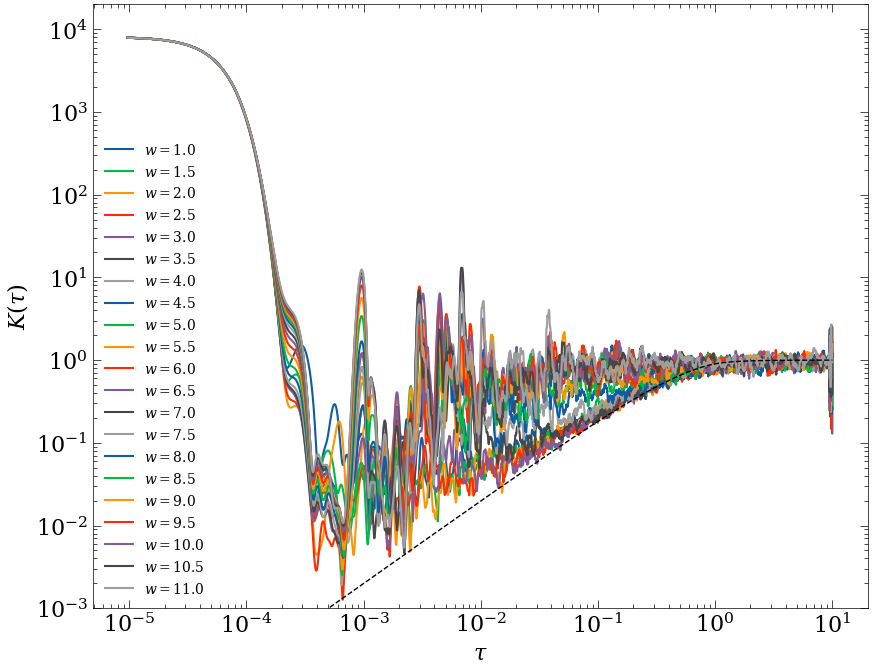

In [13]:
L=14
J=1.0
alfa=0.98
h=0.0
w=1.3
zeta=0.2
M=3
gamma=1.0
ini_ave=1

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,8), dpi = 100)

FOLDED = False

alfa_vals = np.linspace(0.7, 0.85, 16)
w_vals = np.linspace(1.0, 11.0, 21)
sizes = np.arange(10, 16, 1)
times = [1]
#for L in sizes:
#for alfa in alfa_vals:
for w in w_vals:
    filename = dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave)
    if exists(filename):
        data = pd.read_table(filename, sep="\t", header=None)
        times = np.array(data[0])
        sff = np.array(data[1])
        sff = remove_fluctuations(sff, int(0.005 * len(sff)))
        tH = data[2][0]
        gap_ratio = data[4][0]
        axis.plot(times, sff, lw=1.5, label=r"$w=%.1f$"%w)
    else:
        print(filename)

axis.plot(times, GOE(times), ls='--', color='black')
#axis.axhline(y=0.38, ls=':', lw=2, color='black')
axis.legend()
axis.set_ylim(1e-3, 2e4)
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_ylabel(r"$K(\tau)$", fontsize=16)
axis.set_xlabel(r"$\tau$", fontsize=16)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_ylim(0, 1.1)

[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11. ]


No handles with labels found to put in legend.


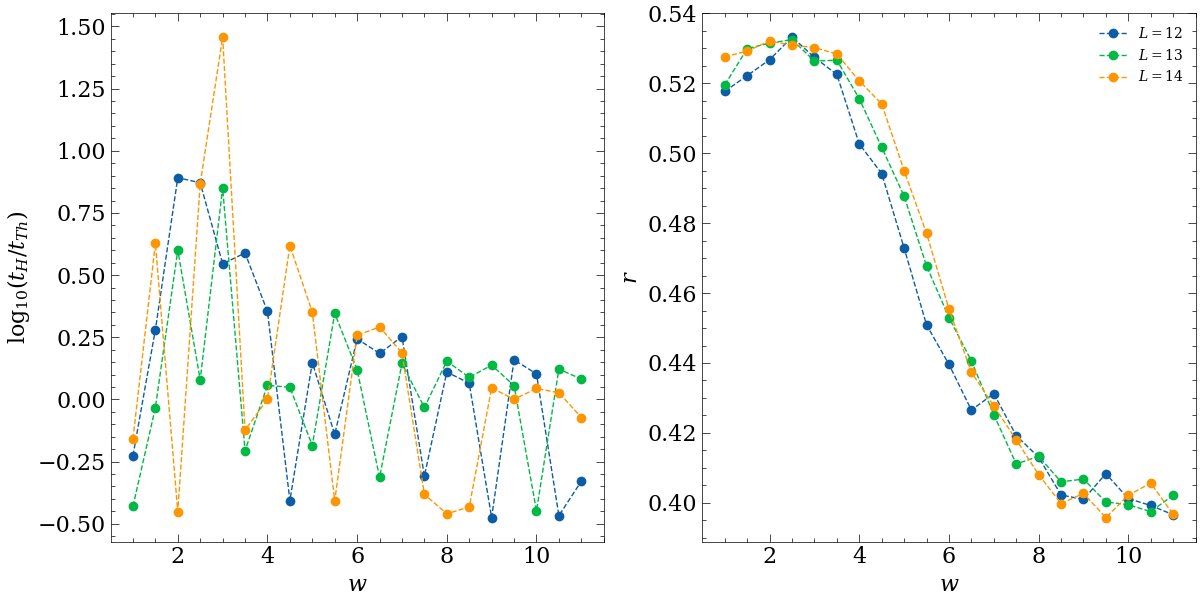

In [41]:

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(14,7), dpi = 100)

FOLDED = False
gamma=1.2

taus = []
gaps = []
heisenberg_time = []
times = [1]
#w_vals = np.linspace(0.2, 4.0, 20)
print(w_vals)
epsilon=8e-2
sizes = [12, 13, 14]
for L in sizes:
    tau_L = []
    tH_L = []
    gaps_L = []
    #for alfa in alfa_vals:
    for w in w_vals:
    
        filename = dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave)
        if exists(filename):
            data = pd.read_table(filename, sep="\t", header=None)
            times = np.array(data[0])
            sff = np.array(data[1])
            sff = remove_fluctuations(sff, int(0.01 * len(sff)))
            tH = data[2][0]
            gap_ratio = data[4][0]
            times_for_algorithm = times / tH if FOLDED else times
            sff_dev = np.abs(np.log10(sff / GOE(times_for_algorithm)))
            tau = np.nan
            for i, K in reversed(list(enumerate(sff_dev))):
                if K > epsilon and times[i] < (3 * tH if FOLDED else 3):
                    tau = times[i-1]
                    break
            tau_L.append(tau)
            tH_L.append(tH)
            gaps_L.append(gap_ratio)
            
            #axis.plot(times, sff, lw=1.5, label=r"$L=%d$"%L)
        else:
            tau_L.append(np.nan)
            tH_L.append(np.nan)
            gaps_L.append(np.nan)
            print(filename)
    tau_L = np.array(tau_L)
    tH_L = np.array(tH_L)

    taus.append(tau_L)
    heisenberg_time.append(tH_L)

    g_cond = np.log10(1.0 / tau_L)
    
    t_Th = tau_L / tH_L / np.exp(L/2)
    axis[0].plot((w_vals), g_cond, ls='--', marker='o')
    axis[1].plot((w_vals), gaps_L, ls='--', marker='o', label=r"$L=%d$"%L)
    
#axis.plot(times, GOE(times), ls='--', color='black')
axis[0].set_ylabel(r"$\log_{10}(t_H/t_{Th})$", fontsize=16)
axis[1].set_ylabel(r"$r$", fontsize=16)
for ax in axis:
    ax.set_xlabel(r"$w$", fontsize=16)
    
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
    ax.legend()
#axis.set_ylim(0, 1.1)
#axis[1].set_xlim(0,7)

In [20]:

FOLDED = False

taus = []
gaps1 = []
gaps2 = []
heisenberg_time = []
times = [1]
w_vals = np.linspace(1.0, 11., 21)
gamma_vals = np.linspace(1.0, 4.0, 16)
print(w_vals, gamma_vals)

n_siz = len(gamma_vals)
m_siz = len(w_vals)
epsilon=8e-2
for L in sizes:
    tau_L = np.zeros((n_siz, m_siz))
    tH_L = np.zeros((n_siz, m_siz))
    gaps1_L = np.zeros((n_siz, m_siz))
    gaps2_L = np.zeros((n_siz, m_siz))
    #for alfa in alfa_vals:
    for ii, gamma in enumerate(gamma_vals):
        for jj, w in enumerate(w_vals):
        
            filename = dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave)
            if exists(filename):
                data = pd.read_table(filename, sep="\t", header=None)
                times = np.array(data[0])
                sff = np.array(data[1])
                sff = remove_fluctuations(sff, int(0.01 * len(sff)))
                tH = data[2][0]
                times_for_algorithm = times / tH if FOLDED else times
                sff_dev = np.abs(np.log10(sff / GOE(times_for_algorithm)))
                tau = np.nan
                for i, K in reversed(list(enumerate(sff_dev))):
                    if K > epsilon and times[i] < (3 * tH if FOLDED else 3):
                        tau = times[i-1]
                        break

                tau_L[ii, jj] = (tau)
                tH_L[ii, jj] = (tH)

                gap_ratio = data[4][0]
                gaps1_L[ii, jj] = (gap_ratio)

                gap_ratio = data[5][0]
                gaps2_L[ii, jj] = (gap_ratio)
                
                #axis.plot(times, sff, lw=1.5, label=r"$L=%d$"%L)
            else:
                tau_L[ii, jj] = (np.nan)
                tH_L[ii, jj] = (np.nan)
                gaps1_L[ii, jj] = (np.nan)
                gaps2_L[ii, jj] = (np.nan)
                print(filename)

    taus.append(np.array(tau_L))
    heisenberg_time.append(np.array(tH_L))
    gaps1.append(np.array(gaps1_L))
    gaps2.append(np.array(gaps2_L))

    #g_cond = np.log10(1.0 / tau_L)
    #
    #t_Th = tau_L / tH_L / np.exp(L/2)
    #axis[0].plot(w_vals / L, g_cond, ls='--', marker='o')
    #axis[1].plot(w_vals / L, gaps_L, ls='--', marker='o', label=r"$L=%d$"%L)
    


[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11. ] [1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4. ]
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=1.00,ini_ave=1.dat
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=1.50,ini_ave=1.dat
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=2.00,ini_ave=1.dat
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=2.50,ini_ave=1.dat
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=3.00,ini_ave=1.dat
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=3.50,ini_ave=1.dat
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=4.00,ini_ave=1.dat
../results/SpectralFormFactor/_L=15,M=3,J=1.00,g=1.00,zeta=0.20,alfa=0.98,h=0.00,w=4.50,ini_ave=1.dat
../results

No handles with labels found to put in legend.
No handles with labels found to put in legend.


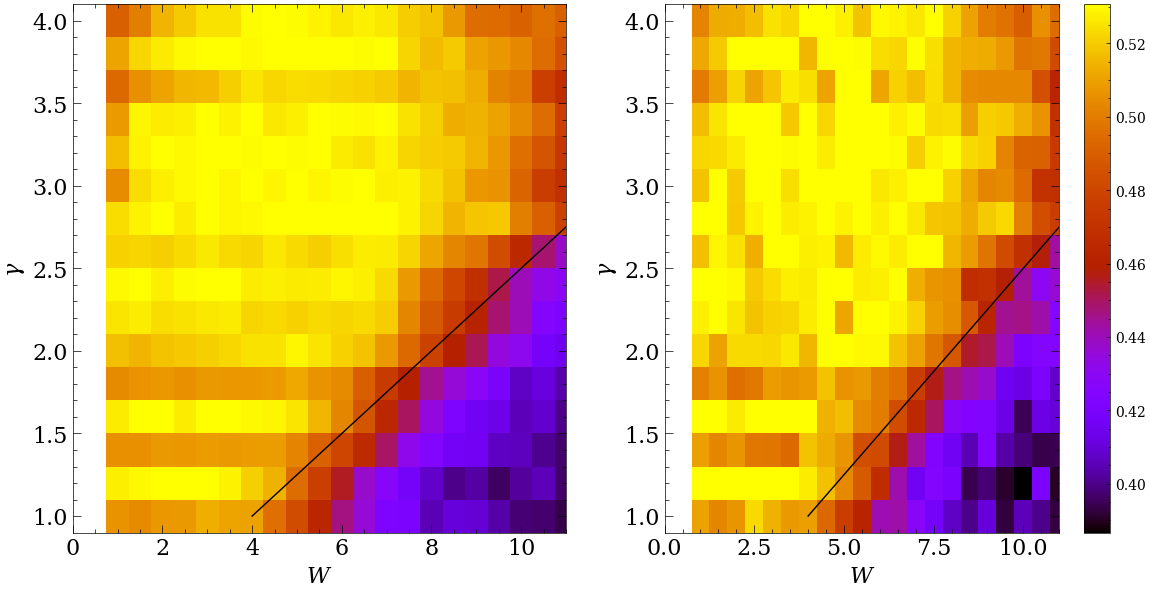

In [44]:

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(14,7), dpi = 100)

X, Y = np.meshgrid(w_vals, gamma_vals)
#axis.plot(times, GOE(times), ls='--', color='black')

L = 14

idx = list(sizes).index(L)
idx=-2
axis[0].pcolormesh(X, Y, (gaps1[idx]), shading='nearest', vmin = 0.3867, vmax=0.5307, cmap = 'gnuplot')
p = axis[1].pcolormesh(X, Y, (gaps2[idx]), shading='nearest', vmin = 0.3867, vmax=0.5307, cmap = 'gnuplot')
for ax in axis:
    ax.set_ylabel(r"$\gamma$", fontsize=16)
    ax.set_xlabel(r"$W$", fontsize=16)
    
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
    ax.legend()
    ax.plot(4.*gamma_vals, gamma_vals, color='black')
    ax.set_xlim(0,11)
fig.colorbar(p)
 
#axis.set_ylim(0, 1.1)

selected L more averaginig

L->13+3

sweep J (g0) with disorder=[-W,W] and alfa=1,  0.98

entangelmenet entropy most disorderered spins (one, two,..) take rho_B cause they are last spins

order when alfa=1